### Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

In [1]:
import pandas as pd 
import numpy as np

import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_user_data = pd.read_csv('ab_users_data.csv')
df_order = pd.read_csv('ab_orders.csv')
df_products = pd.read_csv('ab_products.csv')

## Предварительное изучение данных

### df_user_data 
Данные: 
- user_id - id пользователя
- order_id - id заказа
- action - действие ('create_order', 'cancel_order')
- time - время совершения действия
- date - дата
- group - группа (0 - контрольная, 1 - экспериментальная)

In [3]:
df_user_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
df_user_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [5]:
df_user_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [6]:
df_user_data['time'] = pd.to_datetime(df_user_data['time'])
df_user_data['date'] = pd.to_datetime(df_user_data['date'], format='%Y-%m-%d')

In [7]:
df_user_data.shape

(4337, 6)

In [8]:
df_user_data.groupby('group')\
    .agg({'order_id':'count'})

,order_id
group,
0,1691
1,2646


In [9]:
df_user_data.user_id.nunique()

1017

In [10]:
df_user_data.order_id.nunique()

4123

### df_order  

Данные:
- order_id - id заказа
- creation_time - время создания заказа
- product_ids - список продуктов 

In [11]:
df_order.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [12]:
df_order.shape

(4123, 3)

In [13]:
df_order.order_id.nunique()

4123

In [14]:
df_order.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [15]:
df_order['creation_time'] = pd.to_datetime(df_order['creation_time'])

### df_products  
Данные:
- product_id - id продукта
- name - наименование
- price - цена за единицу товара

In [16]:
df_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [17]:
df_products.shape

(87, 3)

In [18]:
df_products.product_id.nunique()

87

In [19]:
df_products.price.agg(['min', 'max'])

min      1.0
max    800.0
Name: price, dtype: float64

### Выводы (предварительный анализ): 
1. В датасете df_user_data есть отмененные заказы, которые нужно учесть при анализе
2. df_order.creation_time == df_user_data.time при df_user_data.action == create_order

## Метрики и гипотезы


*Метрики:*
- количество заказов на пользователя 
- выручка на пользователя

Гиротезы:  
$H_0$ - Средние значения количества заказов на пользователя равны в контрольной и экспериментальной группах  
$H_1$ - Средние значения количества заказов на пользователя не равны в контрольной и экспериментальной группах

$H_0$ - Средние значения выручки на пользователя равны в контрольной и экспериментальной группах  
$H_1$ - Средние значения выручки на пользователя не равны в контрольной и экспериментальной группах

## Найдем необходимые метрики

In [20]:
# перевод айдишников продуктов в список  
def list_product_ids(x):
    x = x[1:-1]
    id_product = list(map(int, x.split(',')))
    return id_product

In [21]:
# подсчет суммы покупки
def purchase_amount(x):
    result = 0
    for item in x:
        result += df_products.iloc[df_products.query(f'product_id == {item}').index[0]]['price']
    return result

In [22]:
df_order['product_ids'] = df_order.product_ids.apply(list_product_ids)

In [23]:
df_order['purchase_amount'] = df_order.product_ids.apply(purchase_amount)

### Формирование общего датасета 
Необходимо исключить заказы, которые отменили

In [26]:
cancel_order_list = list(df_user_data.order_id[df_user_data.action == 'cancel_order'])

In [27]:
df_user_no_cancel_order = df_user_data[~ df_user_data.order_id.isin(cancel_order_list)]

In [28]:
df = df_user_no_cancel_order.merge(df_order, how='inner', on='order_id')

In [29]:
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,purchase_amount
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,"[30, 35, 69, 6]",430.7


In [55]:
df_users_order = df.groupby(['group', 'user_id'], as_index=False)\
    .agg({'purchase_amount':'sum', 'order_id': pd.Series.nunique})\
    .rename(columns={'purchase_amount':'proceeds_by_user', 'order_id': 'count_orders_by_user'})

In [56]:
df_users_order.head()

,group,user_id,proceeds_by_user,count_orders_by_user
0,0,964,718.9,2
1,0,968,1590.7,3
2,0,969,681.9,2
3,0,972,546.4,1
4,0,975,1432.9,2


### Графики

Text(0, 0.5, 'Приыль с 1 пользователя')

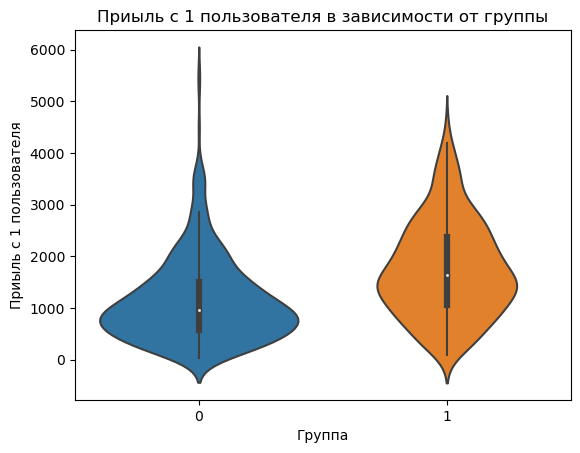

In [57]:
sns.violinplot(x = 'group', y = 'proceeds_by_user', data = df_users_order)
plt.title('Приыль с 1 пользователя в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('Приыль с 1 пользователя')

Text(0, 0.5, 'Количество заказов')

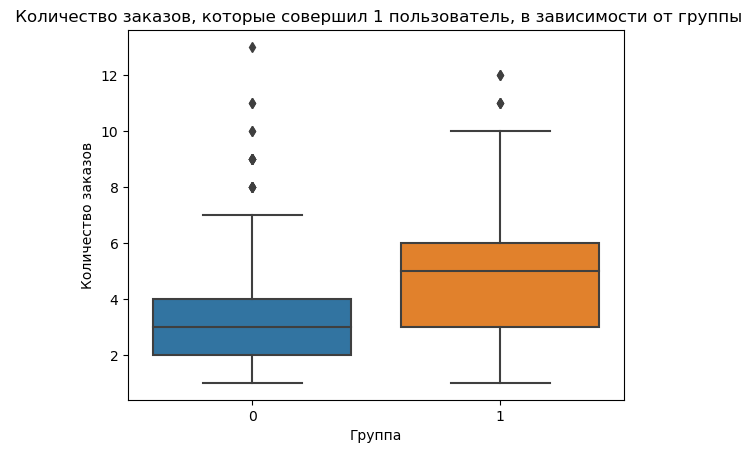

In [58]:
sns.boxplot(x = 'group', y = 'count_orders_by_user', data = df_users_order)
plt.title(' Количество заказов, которые совершил 1 пользователь, в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('Количество заказов')

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


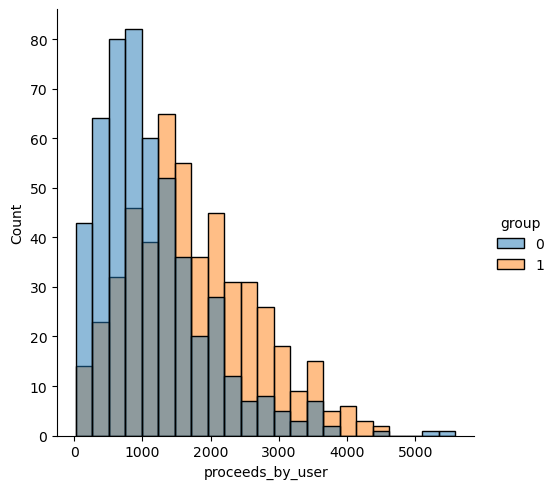

In [59]:
sns.displot(x='proceeds_by_user', hue='group' , data=df_users_order)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

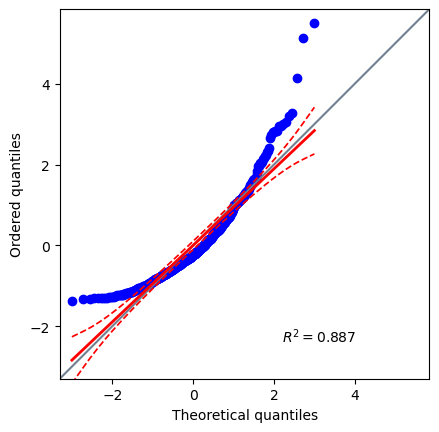

In [69]:
pg.qqplot(df_users_order.query("group == 0").proceeds_by_user)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

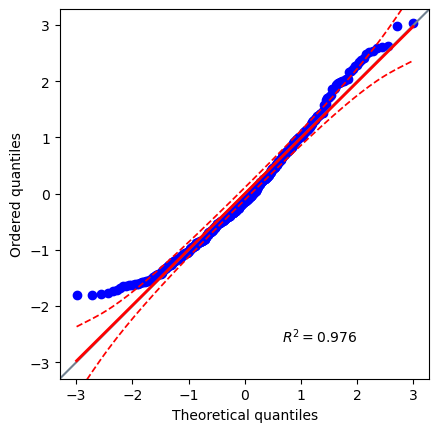

In [70]:
pg.qqplot(df_users_order.query("group == 1").proceeds_by_user)

### Анализ распределений

In [60]:
pg.normality(df_users_order.query('group == 0'), method='normaltest').round(3)

,W,pval,normal
group,NaN,NaN,False
user_id,345.433,0.0,False
proceeds_by_user,165.141,0.0,False
count_orders_by_user,178.267,0.0,False


In [61]:
pg.normality(df_users_order.query("group == 1"), method='normaltest').round(3)

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1808: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


,W,pval,normal
group,NaN,NaN,False
user_id,299.395,0.0,False
proceeds_by_user,21.243,0.0,False
count_orders_by_user,17.211,0.0,False


In [71]:
pg.homoscedasticity(data=df_users_order, dv='count_orders_by_user',
                    group='group', method='levene')

,W,pval,equal_var
levene,17.195942,0.000037,False


In [72]:
pg.homoscedasticity(data=df_users_order, dv='proceeds_by_user',
                    group='group', method='levene')

,W,pval,equal_var
levene,18.466658,0.000019,False


In [67]:
df_users_order.groupby('group', as_index=False)\
    .agg({'user_id':'count'})

,group,user_id
0,0,512
1,1,501


### Выводы:

Было проведено исследование полученных метрик, а именно: количество заказов и выручка на пользователя.
1. Данные показатели распределены "ненормально", а дисперсии выборок негомогенны. 
2. Рассматриваемые группы имеют большую численность, следовательно возможно использовать T-тест
3. Количество наблюдений в двух выборка примерно одинаковы

### Т-тест

*выручка на 1 пользователя*

In [74]:
group_control = np.array(df_users_order.query("group == 0").proceeds_by_user)
group_experiment = np.array(df_users_order.query("group == 1").proceeds_by_user)

In [75]:
pg.ttest(group_control, group_experiment, correction='auto')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.20863,986.457349,two-sided,1.572166e-27,"[-721.72, -506.66]",0.705418,1.963e+24,1.0


*количество заказов*

In [77]:
group_control_count = np.array(df_users_order.query("group == 0").count_orders_by_user)
group_experiment_count = np.array(df_users_order.query("group == 1").count_orders_by_user)

In [78]:
pg.ttest(group_control_count, group_experiment_count, correction='auto')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-13.97417,989.822835,two-sided,1.237410e-40,"[-2.02, -1.52]",0.879358,1.801e+37,1.0


### Вывод
Статистический анализ показал, что с высокой долей вероятности можно утверждать, что метрики в контрольной и экспериментальной группе статистически значимо различаются. В экспериментальной группе количество заказов и выручка на 1 пользователя выше, чем в экспериментальной.